In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math

✅ dual_arm.gif を保存しました。


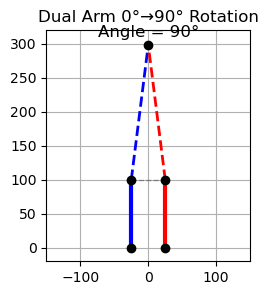

In [ ]:
#--------------------------------------ペンのシミュレーション--------------------------------------
# ===== パラメータ =====
d = 50.0  # モーター間距離 [mm]
l_1 = 100.0  # 下側アームの長さ [mm]
l_2 = 200.0   # 上側アームの長さ [mm]
frames = 91  # 0～90度の1度刻み

# ===== モーターの位置 =====
left_origin = np.array([-d/2, 0.0])
right_origin = np.array([d/2, 0.0])

# ===== モーター側アームの先端位置を計算 =====
def arm_positions(theta_L_deg, theta_R_deg):
    """左右独立角度の下側リンク先端座標を返す"""
    theta_L = np.radians(180 - theta_L_deg)
    theta_R = np.radians(theta_R_deg)
    left_end = left_origin + l_1 * np.array([np.cos(theta_L), np.sin(theta_L)])
    right_end = right_origin + l_1 * np.array([np.cos(theta_R), np.sin(theta_R)])
    return left_end, right_end

# ===== 交点（ペン位置）計算 =====
def intersection_upper(P1, P2, r):
    x1, y1 = P1
    x2, y2 = P2
    dx, dy = x2 - x1, y2 - y1
    d = math.hypot(dx, dy)
    if d > 2*r or d == 0:
        return None
    a = d / 2
    h = math.sqrt(max(r**2 - a**2, 0))
    xm, ym = (x1 + x2)/2, (y1 + y2)/2
    rx, ry = -dy*(h/d), dx*(h/d)
    p_up = np.array([xm + rx, ym + ry])
    p_down = np.array([xm - rx, ym - ry])
    return p_up if p_up[1] >= p_down[1] else p_down

# ===== プロット準備 =====
fig, ax = plt.subplots(figsize=(6, 3))
ax.set_xlim(- (d + l_1), d + l_1)
ax.set_ylim(-l_1 * 0.2, l_1 + l_2 + 20)
ax.set_aspect('equal', 'box')
ax.grid(True)
ax.set_title("Dual Arm 0°→90° Rotation")

moter_left_line, = ax.plot([], [], 'b-', lw=3)
moter_right_line, = ax.plot([], [], 'r-', lw=3)
pen_left_line, = ax.plot([], [], 'b--', lw=2)
pen_right_line, = ax.plot([], [], 'r--', lw=2)
joint_line, = ax.plot([], [], 'k--', lw=1, alpha=0.3)
points, = ax.plot([], [], 'ko', ms=6)
text = ax.text(0, l_1 + l_2 + 10, '', ha='center', fontsize=12)

def init():
    for line in [moter_left_line, moter_right_line, pen_left_line, pen_right_line, joint_line]:
        line.set_data([], [])
    points.set_data([], [])
    text.set_text('')
    return moter_left_line, moter_right_line, pen_left_line, pen_right_line, joint_line, points, text

def update(frame):
    angle = frame
    L_end, R_end = arm_positions(angle)
    pen = intersection_upper(L_end, R_end, l_2)

    # モーター側
    moter_left_line.set_data([left_origin[0], L_end[0]], [left_origin[1], L_end[1]])
    moter_right_line.set_data([right_origin[0], R_end[0]], [right_origin[1], R_end[1]])
    joint_line.set_data([L_end[0], R_end[0]], [L_end[1], R_end[1]])

    if pen is not None:
        pen_left_line.set_data([L_end[0], pen[0]], [L_end[1], pen[1]])
        pen_right_line.set_data([R_end[0], pen[0]], [R_end[1], pen[1]])
    else:
        pen_left_line.set_data([], [])
        pen_right_line.set_data([], [])

    x_points = [left_origin[0], right_origin[0], L_end[0], R_end[0]]
    y_points = [left_origin[1], right_origin[1], L_end[1], R_end[1]]
    if pen is not None:
        x_points.append(pen[0])
        y_points.append(pen[1])
    points.set_data(x_points, y_points)

    text.set_text(f"Angle = {angle:.0f}°")
    return moter_left_line, moter_right_line, pen_left_line, pen_right_line, joint_line, points, text

ani = animation.FuncAnimation(
    fig, update, frames=frames, init_func=init, interval=50, blit=False
)
ani.save("dual_arm.gif", writer="pillow", fps=20)
print("✅ dual_arm.gif を保存しました。")

plt.show()


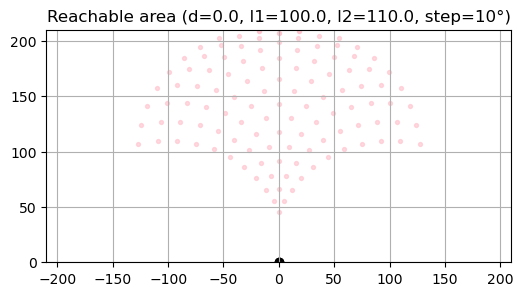

✅ GIFとして保存しました: reachable_area_with_arms.gif


In [ ]:


# ===== パラメータ =====
moter_distance = 20.0     # モーター間距離 [mm]
moter_arm_long = 100.0    # 下側アーム長 [mm]
pen_arm_long = 110.0      # 上側アーム長 [mm]
angle_max = 100           # 最大角度 [deg]
Interval = 10             # 掃引刻み [deg]

# ===== モーター位置 =====
left_origin = np.array([-moter_distance/2, 0.0])
right_origin = np.array([moter_distance/2, 0.0])

# ===== 幾何関数 =====
def arm_positions(theta_L_deg, theta_R_deg):
    """左右独立角度で下側リンク先端を計算"""
    theta_L = np.radians(180 - theta_L_deg)
    theta_R = np.radians(theta_R_deg)
    left_end = left_origin + moter_arm_long * np.array([np.cos(theta_L), np.sin(theta_L)])
    right_end = right_origin + moter_arm_long * np.array([np.cos(theta_R), np.sin(theta_R)])
    return left_end, right_end

def intersection_upper(P1, P2, r):
    """2円の上側交点を求める"""
    x1, y1 = P1
    x2, y2 = P2
    dx, dy = x2 - x1, y2 - y1
    d = math.hypot(dx, dy)
    if d > 2*r or d == 0:
        return None
    a = d / 2
    h = math.sqrt(max(r**2 - a**2, 0))
    xm, ym = (x1 + x2)/2, (y1 + y2)/2
    rx, ry = -dy*(h/d), dx*(h/d)
    p_up = np.array([xm + rx, ym + ry])
    p_down = np.array([xm - rx, ym - ry])
    return p_up if p_up[1] >= p_down[1] else p_down

# ===== 可動域を全探索 =====
def compute_reachable_area_full(d, l_1, l_2, angle_max, step):
    points = []
    angles = np.arange(0, angle_max + 1e-9, step)
    for theta_L in angles:
        for theta_R in angles:
            L_end, R_end = arm_positions(theta_L, theta_R)
            pen = intersection_upper(L_end, R_end, l_2)
            if pen is not None:
                points.append(pen)
    return np.array(points)

# ===== 静止可動域を描画 =====
def plot_reachable_area(points, d, l_1, l_2, step):
    fig, ax = plt.subplots(figsize=(6,5))
    ax.scatter(points[:,0], points[:,1], s=8, color='pink', alpha=0.6)
    ax.scatter([-d/2, d/2], [0,0], c='k', marker='o')
    ax.set_xlim(-l_1-l_2, l_1+l_2)
    ax.set_ylim(0, l_1+l_2)
    ax.set_aspect('equal', 'box')
    ax.grid(True)
    ax.set_title(f"Reachable area (d={d}, l1={l_1}, l2={l_2}, step={step}°)")
    plt.show()

# ===== GIF作成 =====
def make_reachable_area_gif_with_arms(d, l_1, l_2, angle_max, step):
    angles = np.arange(0, angle_max + 1e-9, step)
    total = len(angles) ** 2
    points = []

    fig, ax = plt.subplots(figsize=(6,5))
    ax.set_xlim(-l_1 - l_2, l_1 + l_2)
    ax.set_ylim(0, l_1 + l_2)
    ax.set_aspect('equal', 'box')
    ax.grid(True)
    ax.set_title(f"Pantograph Reachable Area (d={d}, l1={l_1}, l2={l_2}, step={step}°)")

    scatter = ax.scatter([], [], s=8, color='pink', alpha=0.6)
    text = ax.text(0, l_1 + l_2 * 0.9, '', ha='center', fontsize=12)

    # 腕の描画ライン
    lower_left_line, = ax.plot([], [], 'b-', lw=2)
    lower_right_line, = ax.plot([], [], 'r-', lw=2)
    upper_left_line, = ax.plot([], [], 'b--', lw=1.5)
    upper_right_line, = ax.plot([], [], 'r--', lw=1.5)
    joint_line, = ax.plot([], [], 'k:', lw=1)

    def update(frame_idx):
        i = frame_idx // len(angles)
        j = frame_idx % len(angles)
        theta_L = angles[i]
        theta_R = angles[j]

        L_end, R_end = arm_positions(theta_L, theta_R)
        pen = intersection_upper(L_end, R_end, l_2)

        if pen is not None:
            points.append(pen)

        # 下側の腕
        lower_left_line.set_data([left_origin[0], L_end[0]], [left_origin[1], L_end[1]])
        lower_right_line.set_data([right_origin[0], R_end[0]], [right_origin[1], R_end[1]])

        # 上側リンク
        if pen is not None:
            upper_left_line.set_data([L_end[0], pen[0]], [L_end[1], pen[1]])
            upper_right_line.set_data([R_end[0], pen[0]], [R_end[1], pen[1]])
        else:
            upper_left_line.set_data([], [])
            upper_right_line.set_data([], [])

        # 下アーム先端を結ぶ線
        joint_line.set_data([L_end[0], R_end[0]], [L_end[1], R_end[1]])

        # ペン可動域
        scatter.set_offsets(points)
        text.set_text(f"{frame_idx+1}/{total}")

        return (scatter, text, lower_left_line, lower_right_line,
                upper_left_line, upper_right_line, joint_line)

    ani = animation.FuncAnimation(
        fig, update, frames=total, interval=80, blit=False
    )

    ani.save("reachable_area_with_arms.gif", writer="pillow", fps=25)
    print("✅ GIFとして保存しました: reachable_area_with_arms.gif")
    plt.close(fig)

# ===== 実行 =====
if __name__ == "__main__":
    points = compute_reachable_area_full(moter_distance, moter_arm_long, pen_arm_long, angle_max, Interval)
    plot_reachable_area(points, moter_distance, moter_arm_long, pen_arm_long, Interval)
    make_reachable_area_gif_with_arms(moter_distance, moter_arm_long, pen_arm_long, angle_max, Interval)

